In [106]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### NYTimes Data

In [8]:
data_nytimes = pd.read_csv('../data/nytimes_covid19_data/20200405_us-counties.csv')
data_nytimes.tail()

,date,county,state,fips,cases,deaths
33246,2020-04-04,Sublette,Wyoming,56035.0,1,0
33247,2020-04-04,Sweetwater,Wyoming,56037.0,4,0
33248,2020-04-04,Teton,Wyoming,56039.0,36,0
33249,2020-04-04,Uinta,Wyoming,56041.0,2,0
33250,2020-04-04,Washakie,Wyoming,56043.0,2,0


In [6]:
data_nytimes.shape

(33251, 6)

In [60]:
data_nytimes['county_state'] = data_nytimes.county + ', ' + data_nytimes.state
data_nytimes.head()

,date,county,state,fips,cases,deaths,county_state
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Cook, Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Snohomish, Washington"


In [92]:
# find top n counties with largest cumulative cases
top_n = 10
counties = data_nytimes.groupby('county_state').sum().cases.nlargest(top_n).index.tolist()

In [114]:
data = data_nytimes[data_nytimes['county_state'].isin(counties)]
data.tail()

,date,county,state,fips,cases,deaths,county_state
32267,2020-04-04,Nassau,New York,36059.0,13346,396,"Nassau, New York"
32268,2020-04-04,New York City,New York,NaN,63307,2254,"New York City, New York"
32289,2020-04-04,Suffolk,New York,36103.0,12328,175,"Suffolk, New York"
32298,2020-04-04,Westchester,New York,36119.0,13080,197,"Westchester, New York"
33124,2020-04-04,King,Washington,53033.0,2900,204,"King, Washington"


In [107]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 3 to 33124
Data columns (total 7 columns):
date            387 non-null datetime64[ns]
county          387 non-null object
state           387 non-null object
fips            328 non-null float64
cases           387 non-null int64
deaths          387 non-null int64
county_state    387 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 24.2+ KB


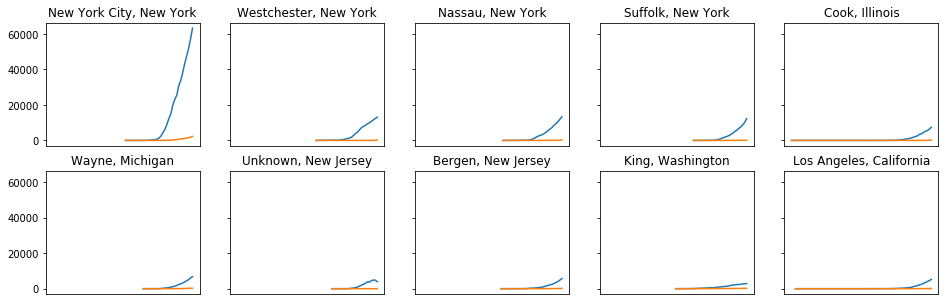

In [100]:
# initial plot
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties,axes.flat):
    data_per_county = data[data['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)

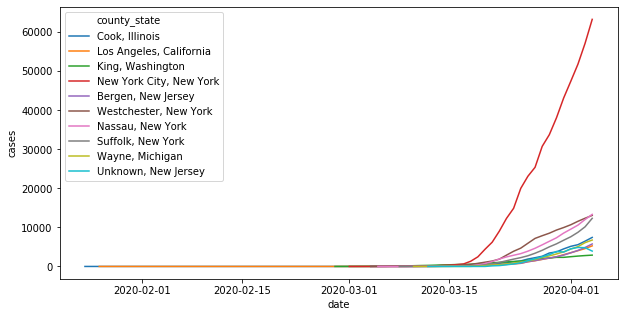

In [108]:
fig, ax = plt.subplots(figsize = (10,5))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data, x='date', y='cases', hue='county_state')

In [110]:
# data only after 2020-03-01
data_halftime = data[(data['date'] > '2020-03-01')]


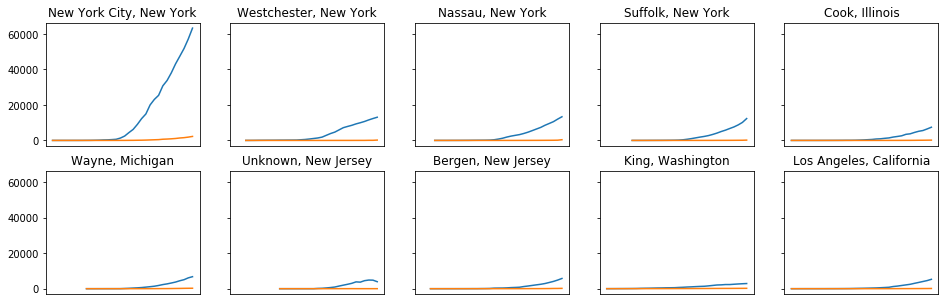

In [111]:
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties,axes.flat):
    data_per_county = data_halftime [data_halftime ['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)

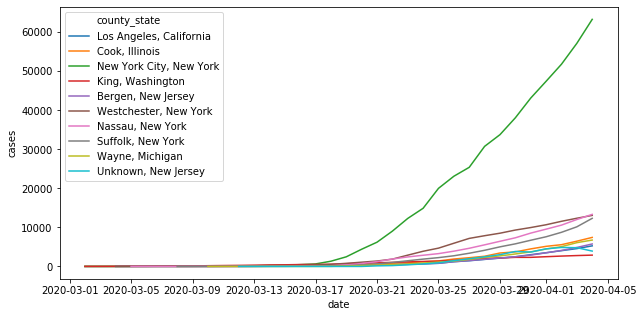

In [113]:
fig, ax = plt.subplots(figsize = (10,5))
#ax.plot(data_per_county.date, data_per_county.cases)
sns.lineplot(data=data_halftime, x='date', y='cases', hue='county_state');

In [115]:
counties

['New York City, New York',
 'Westchester, New York',
 'Nassau, New York',
 'Suffolk, New York',
 'Cook, Illinois',
 'Wayne, Michigan',
 'Unknown, New Jersey',
 'Bergen, New Jersey',
 'King, Washington',
 'Los Angeles, California']

In [118]:
# without nyc
counties_no_nyc = data_nytimes.groupby('county_state').sum().cases.nlargest(top_n).index.tolist()[1:]
data_no_nyc = data_halftime[data_halftime['county_state'].isin(counties_no_nyc)]
data_no_nyc.tail()

,date,county,state,fips,cases,deaths,county_state
32212,2020-04-04,Unknown,New Jersey,NaN,3935,11,"Unknown, New Jersey"
32267,2020-04-04,Nassau,New York,36059.0,13346,396,"Nassau, New York"
32289,2020-04-04,Suffolk,New York,36103.0,12328,175,"Suffolk, New York"
32298,2020-04-04,Westchester,New York,36119.0,13080,197,"Westchester, New York"
33124,2020-04-04,King,Washington,53033.0,2900,204,"King, Washington"


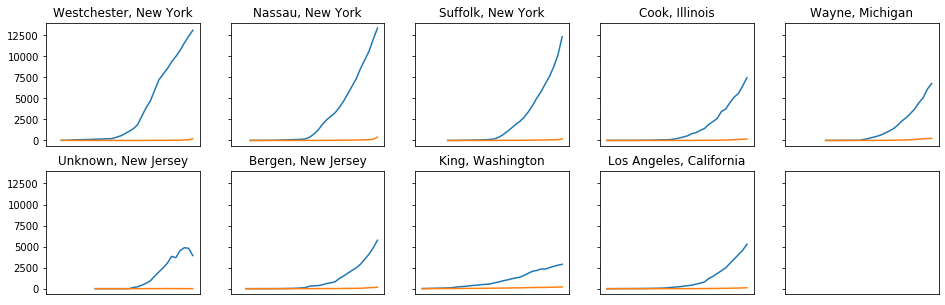

In [120]:
fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties_no_nyc,axes.flat):
    data_per_county = data_no_nyc[data_no_nyc['county_state'] == county]
    ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)

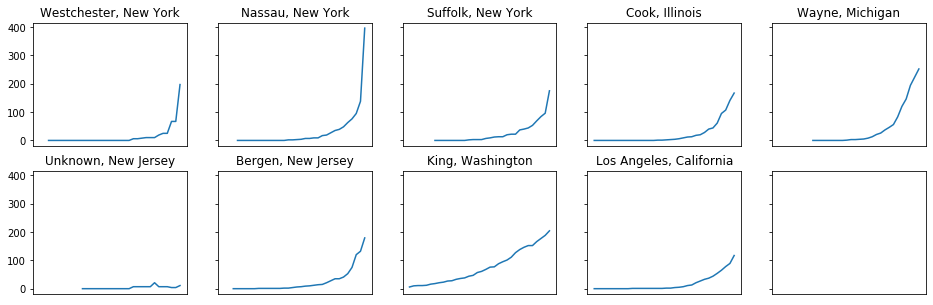

In [121]:
# just morality rate

fig, axes = plt.subplots(2,5, figsize = (16,5), sharex=True, sharey=True, subplot_kw={ 'xticks': []})

for county, ax in zip(counties_no_nyc,axes.flat):
    data_per_county = data_no_nyc[data_no_nyc['county_state'] == county]
    #ax.plot(data_per_county.date, data_per_county.cases)
    ax.plot(data_per_county.date, data_per_county.deaths)
    ax.set_title(county)

### JHU Data

In [10]:
data_jhu = pd.read_csv('../data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
data_jhu.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,51,55,56,58,69,77,82,84,93,112
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,2,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,79,100,127,174,239,286,316,316,452,475
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,19,22,0,0,30,30,30,37,40,42


In [7]:
data_jhu.shape

(3253, 86)

In [32]:
# top 10 counties with largest confirmed cases on 4/5/20
top10_index = data_jhu['4/5/20'].nlargest(10).index.tolist()

In [34]:
data_top10 = data_jhu.iloc[top10_index]
data_top10

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,...,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551
1862,84036059,US,USA,840,36059.0,Nassau,New York,US,40.740665,-73.589419,...,4657,5537,6445,7344,8544,9554,10587,12024,13346,14398
1892,84036119,US,USA,840,36119.0,Westchester,New York,US,41.162784,-73.757417,...,7187,7875,8519,9326,9967,10683,11567,12351,13081,13723
1884,84036103,US,USA,840,36103.0,Suffolk,New York,US,40.883201,-72.801217,...,3385,4138,5023,5791,6713,7605,8746,10154,11370,13129
615,84017031,US,USA,840,17031.0,Cook,Illinois,US,41.841448,-87.816588,...,2239,2613,3445,3727,4496,5152,5575,6111,7439,8034
1317,84026163,US,USA,840,26163.0,Wayne,Michigan,US,42.280984,-83.281255,...,1810,2316,2704,3195,3735,4470,5069,6096,6762,7518
1780,84034003,US,USA,840,34003.0,Bergen,New Jersey,US,40.960109,-74.071643,...,1505,1838,2169,2482,2909,3494,4099,4866,5760,6187
209,84006037,US,USA,840,6037.0,Los Angeles,California,US,34.308284,-118.228241,...,1465,1465,1829,2474,3019,3518,4045,4566,4605,5955
1876,84036087,US,USA,840,36087.0,Rockland,New York,US,41.150279,-74.025605,...,1457,1896,2209,2511,2863,3321,3751,4289,4872,5326
367,84012086,US,USA,840,12086.0,Miami-Dade,Florida,US,25.611236,-80.551706,...,763,1003,1192,1632,2123,2202,2886,3364,3890,4146


In [55]:
# drop unnecessary columns
data_top10_cases = data_top10.drop(['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key'], axis = 1)

# add new column with combined county and state
data_top10_cases['county_state'] = data_top10_cases.Admin2 + ', ' + data_top10_cases.Province_State

data_top10_cases = data_top10_cases.drop(['Admin2','Province_State'],axis=1)
data_top10_cases.head()

#data_top10.pivot(columns = 'Admin2')

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,county_state
1863,0,0,0,0,0,0,0,0,0,0,...,29776,33768,37453,43119,47439,51809,57159,63306,67551,"New York, New York"
1862,0,0,0,0,0,0,0,0,0,0,...,5537,6445,7344,8544,9554,10587,12024,13346,14398,"Nassau, New York"
1892,0,0,0,0,0,0,0,0,0,0,...,7875,8519,9326,9967,10683,11567,12351,13081,13723,"Westchester, New York"
1884,0,0,0,0,0,0,0,0,0,0,...,4138,5023,5791,6713,7605,8746,10154,11370,13129,"Suffolk, New York"
615,0,0,1,1,1,1,1,1,1,2,...,2613,3445,3727,4496,5152,5575,6111,7439,8034,"Cook, Illinois"


In [59]:
# reshape data
d = data_top10_cases.melt(id_vars=['county_state'], 
        var_name="date")
        #value_name="Value")
d.tail()

,county_state,date,value
745,"Wayne, Michigan",4/5/20,7518
746,"Bergen, New Jersey",4/5/20,6187
747,"Los Angeles, California",4/5/20,5955
748,"Rockland, New York",4/5/20,5326
749,"Miami-Dade, Florida",4/5/20,4146
